# Truncation for 2, 3 and n-dimensional remapping for nD-Laplace
We updated the proof to correspond to the literature. 
Also, we proofed that:
- Generate a grid $G_n$ with grid unites $v$.
- Generate a $A_n$ for every point $x \in X$ (as pre-processing step)
- Generate a $\epsilon'$ that holds for the area 
- We generate $r' = r_{max}$ based on $A_n$. 
- For any point that $z \notin A_n$ we remap based on $r'$. (Keep angles the same, only the radial distance is re-calculated).
- Otherwise just use $r$ as normal.

We first do this for 2D, 3D and then finally nD-Laplace. 
We have to make sure the truncation is general purpose, to apply it to every implementation.

In [1]:
from Helpers import twod_laplace, helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
non_private_heart_dataset = helpers.load_dataset('../data/heart-dataset/heart_numerical.csv')
non_private_heart_dataset_2d = non_private_heart_dataset.iloc[:, 0:2]
non_private_heart_dataset_2d.head()

/Users/tjibbevanderende/anaconda3/envs/notebook-thesis/lib/python3.8/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dimensions is 2:
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:280: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dimensions is 3:
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:339: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dimensions is 2:
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:342: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dimensions is 3:


,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [2]:
def generate_meshgrid_around_dataset(non_private_dataset, grid_unit):
    min_values = non_private_dataset.min()
    max_values = non_private_dataset.max()
    num_points = ((max_values - min_values) / grid_unit).astype(int) + 1
    ranges = [np.linspace(min_val, max_val, num=num_points[dim]) for dim, (min_val, max_val) in enumerate(zip(min_values, max_values))]
    meshgrid = np.meshgrid(*ranges)
    
    # Convert the meshgrid to a DataFrame
    meshgrid = pd.DataFrame({f'x{i}': meshgrid[i].flatten() for i in range(len(meshgrid))})
    
    return meshgrid


def plot_meshgrid(meshgrid, title="Meshgrid Visualization"):
    plt.figure(figsize=(8, 8))
    plt.scatter(meshgrid['x0'], meshgrid['x1'], marker='.', color='b')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.title(title)
    plt.grid()
    plt.show()

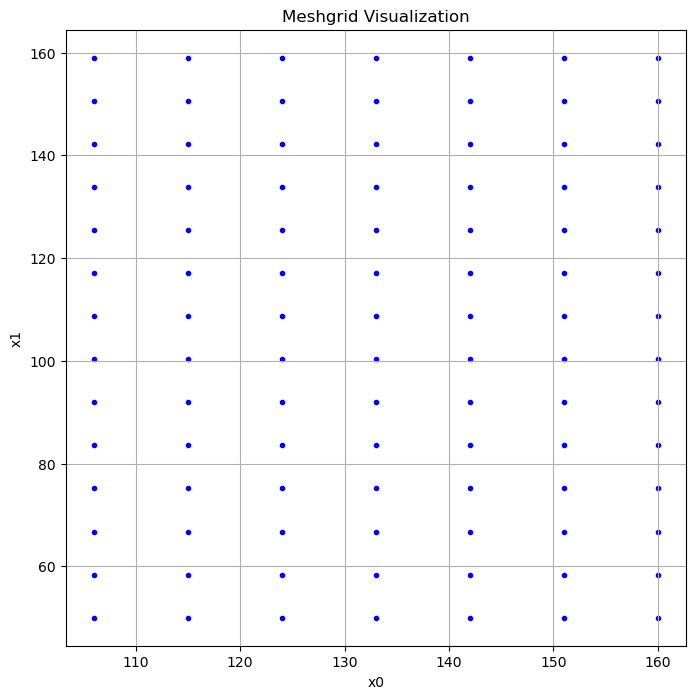

In [3]:
meshgrid_test = generate_meshgrid_around_dataset(non_private_heart_dataset_2d, 8)
plot_meshgrid(meshgrid_test)

In [4]:
from scipy.spatial import KDTree
from scipy.spatial.distance import pdist, squareform
def generate_A_G(non_private_dataset, mesh_grid, grid_unit):
    df_data = non_private_dataset.copy()
    kd_tree = KDTree(df_data)
    grid_unit_size = grid_unit
    results = []
    # Calculate the upper bound and lower bound of the meshgrid
    upper_bound = mesh_grid.max(axis=0)
    lower_bound = mesh_grid.min(axis=0)
    
    for center_index, center in df_data.iterrows():
        # Points within the grid unit around center using euclidean distance
        points_within_grid_unit = kd_tree.query(center, grid_unit_size)
        # Filter df_data to only contain points within the grid unit
        points_within_grid_unit = df_data.iloc[points_within_grid_unit[1]]
        # Calculate the diameter of the points within the grid unit
        diameter =  pdist(points_within_grid_unit, 'euclidean').max() if len(points_within_grid_unit) > 1 else grid_unit_size
        diameters = []
        # Check each dimension separately for being outside the boundary
        for dim in df_data.columns:
            dim_index = df_data.columns.get_loc(dim)
            dim_value = center[dim_index]
            
            # Check if the center minus the grid_unit_size is outside the boundary for this dimension
            if center[dim_index] - grid_unit_size < lower_bound[dim_index]:
                # Update the diameter for this dimension to the distance between the center and the lower bound
                dist_to_lower_bound = np.linalg.norm(center[dim_index] - lower_bound[dim_index])
                diameters.append(dist_to_lower_bound)
            
            # Check if the center plus the grid_unit_size is outside the boundary for this dimension
            if center[dim_index] + grid_unit_size > upper_bound[dim_index]:
                # Update the diameter for this dimension to the distance between the center and the upper bound
                dist_to_upper_bound = np.linalg.norm(center[dim_index] - upper_bound[dim_index])
                diameters.append(dist_to_upper_bound)
        
        # Calculate the radius r_prime
        r_prime = min(diameters) if len(diameters) > 0 else diameter
        
        results.append(r_prime)
        
    return results
    
def perturb_dataset(non_private_df, epsilon, grid_unit, mesh_grid, columns=['baseline value', 'histogram_min']):
    non_private_df_copy = non_private_df.copy()
    private_df = generate_2d_noise_for_dataset(non_private_df_copy, epsilon)
    private_df['r_prime'] = generate_A_G(non_private_df_copy, mesh_grid, grid_unit)
    
    for index, row in non_private_df_copy.iterrows():
        x1, y1 = row[columns]
        # Get r inside private_df on same index
        r = private_df.at[index, 'r']
        # Get r_prime inside private_df on same index
        r_prime = private_df.at[index, 'r_prime']
        # If the distance is greater than r_prime, adjust the private point to lie on the boundary
        if r > r_prime:
            # convert x1, y1 to polar coordinates
            angle = np.arctan2(y1, x1)
            # convert r_prime to polar rho
            #rho = np.sqrt(x1**2 + y1**2)
            x2 = x1 + (r_prime * np.cos(angle))
            y2 = y1 + (r_prime * np.sin(angle))
            private_df.at[index, columns[0]] = x2
            private_df.at[index, columns[1]] = y2

    return private_df

In [5]:
v = 12
meshgrid_test = generate_meshgrid_around_dataset(non_private_heart_dataset_2d, v)
generate_A_G(non_private_heart_dataset_2d, meshgrid_test, v)


[3.0,
 2.23606797749979,
 1.4142135623730951,
 3.0,
 3.0,
 0.0,
 0.0,
 2.23606797749979,
 2.23606797749979,
 2.23606797749979,
 6.0,
 6.0,
 5.0,
 3.1622776601683795,
 4.0,
 4.0,
 3.0,
 3.1622776601683795,
 9.0,
 3.0,
 4.0,
 7.0,
 4.0,
 2.8284271247461903,
 2.8284271247461903,
 3.605551275463989,
 3.605551275463989,
 3.605551275463989,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 3.0,
 1.0,
 2.0,
 2.0,
 0.0,
 3.0,
 5.0,
 4.0,
 5.0,
 2.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0,
 10.0,
 2.23606797749979,
 8.0,
 8.0,
 11.0,
 2.23606797749979,
 6.324555320336759,
 2.23606797749979,
 4.123105625617661,
 2.23606797749979,
 2.23606797749979,
 4.242640687119285,
 10.0,
 6.4031242374328485,
 4.47213595499958,
 4.47213595499958,
 1.4142135623730951,
 4.0,
 3.1622776601683795,
 3.1622776601683795,
 3.1622776601683795,
 3.1622776601683795,
 6.0,
 10.0,
 7.0,
 7.0,
 6.0,
 7.0,
 6.0,
 10.0,
 7.615773105863909,
 7.810249675906654,
 3.605551275463989,
 0.0,
 3.0,
 3.1622776601683795,
 2.0,
 4.0,


In [6]:
import pandas as pd
from Helpers import twod_laplace, helpers
import numpy as np
import random

def generate_2d_noise_for_point(non_private_row: np.array, epsilon):
    p = random.random()
    theta = np.random.rand() * np.pi * 2
    r = twod_laplace.inverseCumulativeGamma(epsilon, p)  # draw radius distance
    private_point = twod_laplace.addVectorToPoint(non_private_row, r, theta)
    return private_point[0], private_point[1], r

def generate_2d_noise_for_dataset(non_private_data: pd.DataFrame, epsilon):
    Z = []
    R = []
    for row in non_private_data.values:
        private_data_point = generate_2d_noise_for_point(row, epsilon)
        Z.append(private_data_point[:2])
        R.append(private_data_point[2])
    return pd.concat((pd.DataFrame(Z, columns=non_private_data.columns), pd.DataFrame(R, columns=['r'])), axis=1)


In [7]:
epsilon = 0.1
with_remapping_2d = perturb_dataset(non_private_heart_dataset_2d, epsilon, v, meshgrid_test)
without_remapping_2d = generate_2d_noise_for_dataset(non_private_heart_dataset_2d, epsilon)

In [8]:
with_remapping_2d.max()

baseline value    160.000000
histogram_min     159.000000
r                  91.396893
r_prime            11.000000
dtype: float64

In [9]:
from matplotlib import pyplot as plt


def visualize_scatterplots(non_private_heart_dataset_2d, without_remapping, with_remapping, title1, title2, meshgrid=None):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    
    # Scatterplot real data
    axes[0].scatter(non_private_heart_dataset_2d.iloc[:, 0], non_private_heart_dataset_2d.iloc[:, 1], alpha=0.5, label='Real data', c='r', marker='x')
    axes[0].set_title('Real data')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()
    
    
    # Scatterplot for non_private DataFrame
    axes[1].scatter(without_remapping.iloc[:, 0], without_remapping.iloc[:, 1], label=title1,  c='b', marker='o')
    axes[1].set_title(title1)
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].legend()

    # Scatterplot for private DataFrame
    axes[2].scatter(with_remapping.iloc[:, 0], with_remapping.iloc[:, 1], label=title2, c='g', alpha=0.5, marker='s')
    axes[2].set_title(title2)
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].legend()
    
    # Include the meshgrid
    if meshgrid is not None:
        # Plot a grid from the meshgrid points
        axes[2].scatter(meshgrid['x0'], meshgrid['x1'], marker='.', color='b', s=100)
        #axes[2].grid()
        axes[2].xticks = meshgrid['x0']
        axes[2].yticks = meshgrid['x1']
    plt.show()


In [10]:
with_remapping_2d.min()

baseline value    106.000000
histogram_min      50.000000
r                   0.103484
r_prime             0.000000
dtype: float64

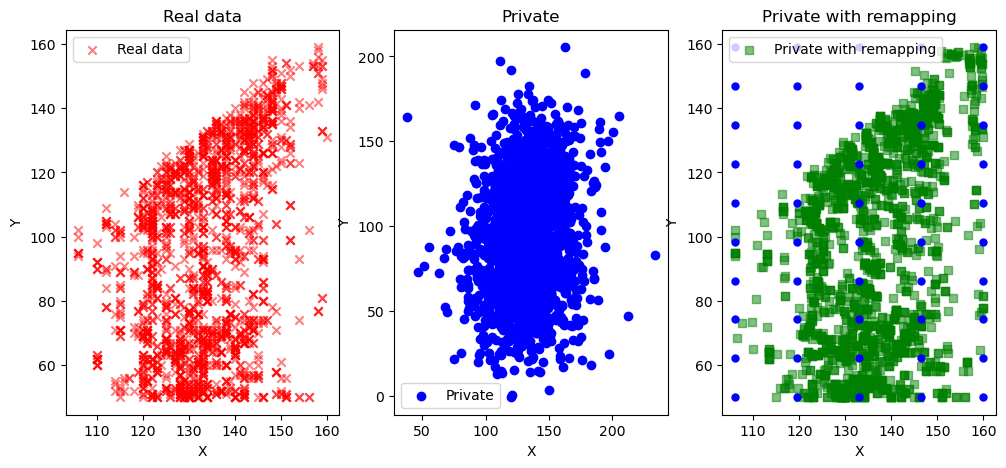

In [11]:
visualize_scatterplots(non_private_heart_dataset_2d, without_remapping_2d, with_remapping_2d, 'Private', 'Private with remapping', meshgrid_test )

In [12]:
circle_dataset = helpers.load_dataset('../data/circle-dataset/circle_1000.csv')
circle_dataset_2d = circle_dataset.iloc[:, 0:2]
circle_dataset_2d.head()

,x1,x2
0,0.047532,0.147264
1,-0.246509,0.076068
2,0.097742,0.054781
3,-0.719132,0.527339
4,0.097023,0.139790


In [13]:

v_circle = 0.2 # grid unit. It is small, as the meshgrid is generated with lower/max bounds based on the original dataset
meshgrid_circle = generate_meshgrid_around_dataset(circle_dataset_2d, v_circle)
without_remapping_circle = generate_2d_noise_for_dataset(circle_dataset_2d, epsilon)
with_remapping_circle = perturb_dataset(circle_dataset_2d, epsilon, v_circle, meshgrid_circle, columns=circle_dataset_2d.columns)

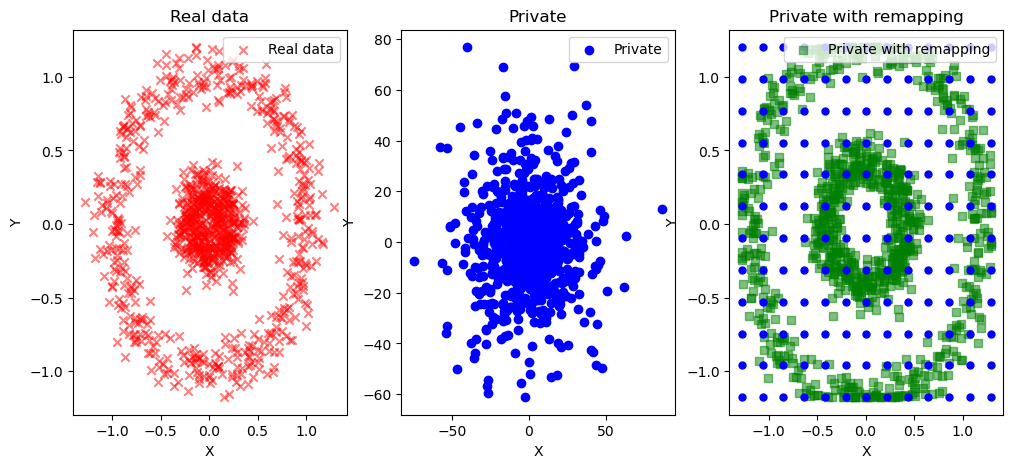

In [14]:
visualize_scatterplots(circle_dataset_2d, without_remapping_circle, with_remapping_circle, 'Private', 'Private with remapping', meshgrid_circle)

## Integrate with ldp_mechanism library

Epsilon  0.1
Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset  using a grid...
All data that was remapped using a grid, is optimally remapped...
Found is_remapped column, so we use that to filter
Points outside domain.... (104, 4)
Shapes (2126, 4) (2126, 3)


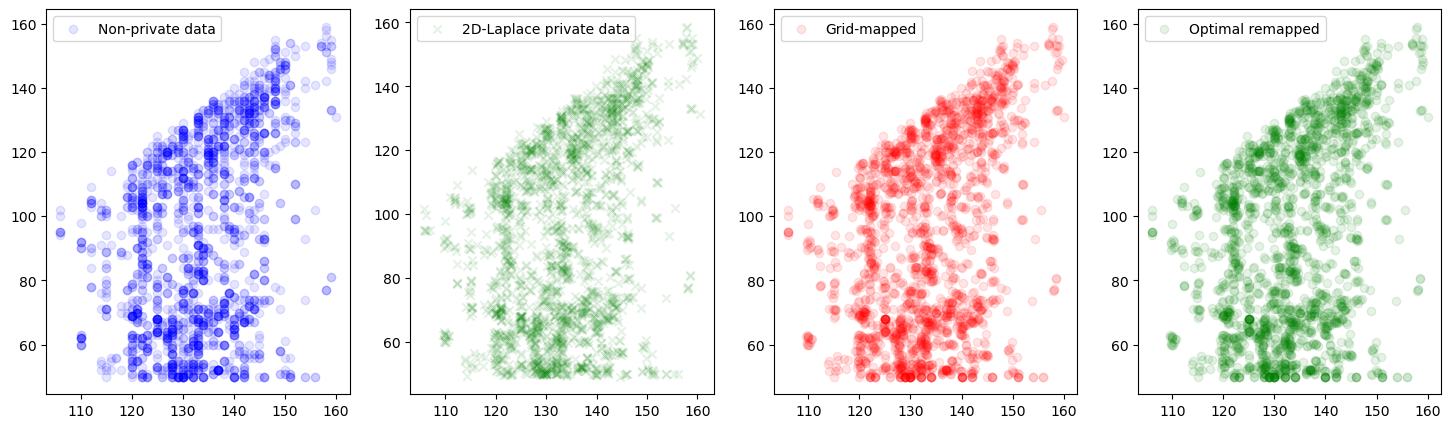

,baseline value,histogram_min
0,119.440294,61.568098
1,131.681761,68.016093
2,133.522793,66.962794
3,134.183168,52.842881
4,131.749122,53.208093
...,...,...
2121,140.018710,136.892649
2122,140.270423,102.819949
2123,139.899438,102.901867
2124,139.831832,103.051364


In [15]:
from Helpers import twod_laplace, ldp_mechanism

print("Epsilon ", epsilon)
heart_mechanism = ldp_mechanism.ldp_mechanism()
heart_mechanism.randomise(non_private_heart_dataset_2d, 5, 12, plot_validation=True)

In [16]:
non_private_heart_dataset_3d = non_private_heart_dataset.iloc[:, 0:3]
non_private_heart_dataset_3d.head()

,baseline value,histogram_min,accelerations
0,120.0,62.0,0.0
1,132.0,68.0,4.0
2,133.0,68.0,2.0
3,134.0,53.0,2.0
4,132.0,53.0,4.0


In [17]:
# Test the means and standard deviation of the original and the private dataset to see if they are similar, we consider epsilons of 0.1, 0.5, 5 and 9
def compare_non_private_and_private_stats(non_private):
    heart_mechanism = ldp_mechanism.ldp_mechanism()

    for epsilon in [0.1, 0.5, 5, 9]:
        print("Epsilon ", epsilon)
        randomized = heart_mechanism.randomise_with_grid(non_private, epsilon, 12)
        # Pretty print the means and standard deviation of the original and the private dataset
        print('Epsilon: ', epsilon)
        # Print value for each column
        for column in randomized.columns:
            # Compare with the original dataset side by side, first non_private then second randomized
            print(column, ' mean: ', non_private[column].mean(), ' std: ', non_private[column].std(), ' | ', randomized[column].mean(), ' std: ', randomized[column].std())
            



In [18]:
compare_non_private_and_private_stats(non_private_heart_dataset_3d)

Epsilon  0.1
Run 3D-Laplace mechanism...


/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))


Epsilon:  0.1
baseline value  mean:  133.3038570084666  std:  9.84084425772098  |  135.11845460567935  std:  9.87813946989966
histogram_min  mean:  93.57949200376294  std:  29.560212256273353  |  94.79396669242924  std:  29.595660969187872
accelerations  mean:  2.722483537158984  std:  3.560850214860175  |  3.152810782386113  std:  3.707982415582616
Epsilon  0.5
Run 3D-Laplace mechanism...


/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))


Epsilon:  0.5
baseline value  mean:  133.3038570084666  std:  9.84084425772098  |  134.21165930999805  std:  9.884842941052847
histogram_min  mean:  93.57949200376294  std:  29.560212256273353  |  94.08353937033  std:  29.554788431928845
accelerations  mean:  2.722483537158984  std:  3.560850214860175  |  3.1344236932973355  std:  3.9009258404373837
Epsilon  5
Run 3D-Laplace mechanism...


/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))


Epsilon:  5
baseline value  mean:  133.3038570084666  std:  9.84084425772098  |  133.32208375326374  std:  9.837807732649736
histogram_min  mean:  93.57949200376294  std:  29.560212256273353  |  93.39176652927723  std:  29.45998015712462
accelerations  mean:  2.722483537158984  std:  3.560850214860175  |  3.133879912837856  std:  3.6532670535445324
Epsilon  9
Run 3D-Laplace mechanism...


/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))


Epsilon:  9
baseline value  mean:  133.3038570084666  std:  9.84084425772098  |  133.3019501441437  std:  9.83965933779228
histogram_min  mean:  93.57949200376294  std:  29.560212256273353  |  93.38916756644453  std:  29.456513468128616
accelerations  mean:  2.722483537158984  std:  3.560850214860175  |  3.143258568243442  std:  3.6595549423139047


From the shifting mean / std can be observed that (even though the results look a lot like each other) still correlate with the privacy budget. (Higher privacy budget, means closer to the original).

Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset  using a grid...


/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:207: RuntimeWarning: invalid value encountered in arccos
  angle_i = np.arccos(cartesian_coords[i] / (r * np.prod(np.sin(polar_angles))))


All data that was remapped using a grid, is optimally remapped...
Found is_remapped column, so we use that to filter
Points outside domain.... (971, 5)
Shapes (2126, 5) (2126, 4)


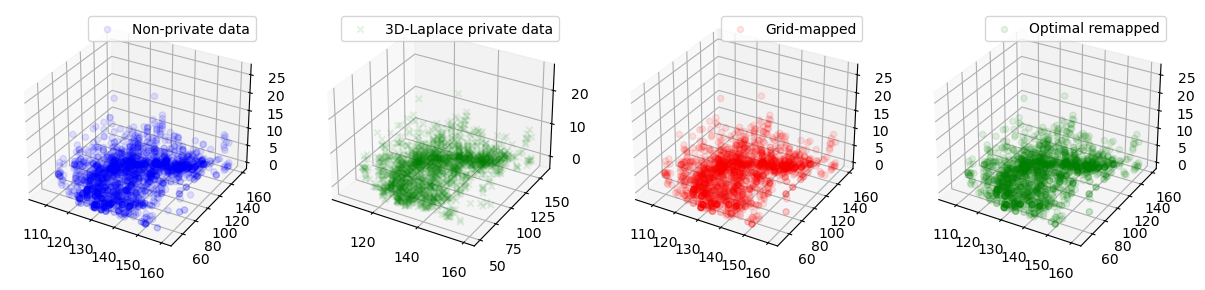

,baseline value,histogram_min,accelerations
0,120.000000,NaN,NaN
1,132.074829,68.018220,4.394403
2,133.278638,68.184504,2.126319
3,133.701323,53.097114,2.341632
4,132.076983,53.134328,4.214969
...,...,...,...
2121,140.000000,137.000000,0.000000
2122,139.981414,102.982572,0.516669
2123,140.078782,103.076154,0.567974
2124,139.882726,102.959268,1.140934


In [19]:
# Scatterplot of 3d version
heart_mechanism.randomise(non_private_heart_dataset_3d, 5, 12, plot_validation=True)


In [20]:
circle_dataset_2d.head()

,x1,x2
0,0.047532,0.147264
1,-0.246509,0.076068
2,0.097742,0.054781
3,-0.719132,0.527339
4,0.097023,0.139790


Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset  using a grid...
All data that was remapped using a grid, is optimally remapped...
Found is_remapped column, so we use that to filter
Points outside domain.... (190, 4)
Shapes (1000, 4) (1000, 3)


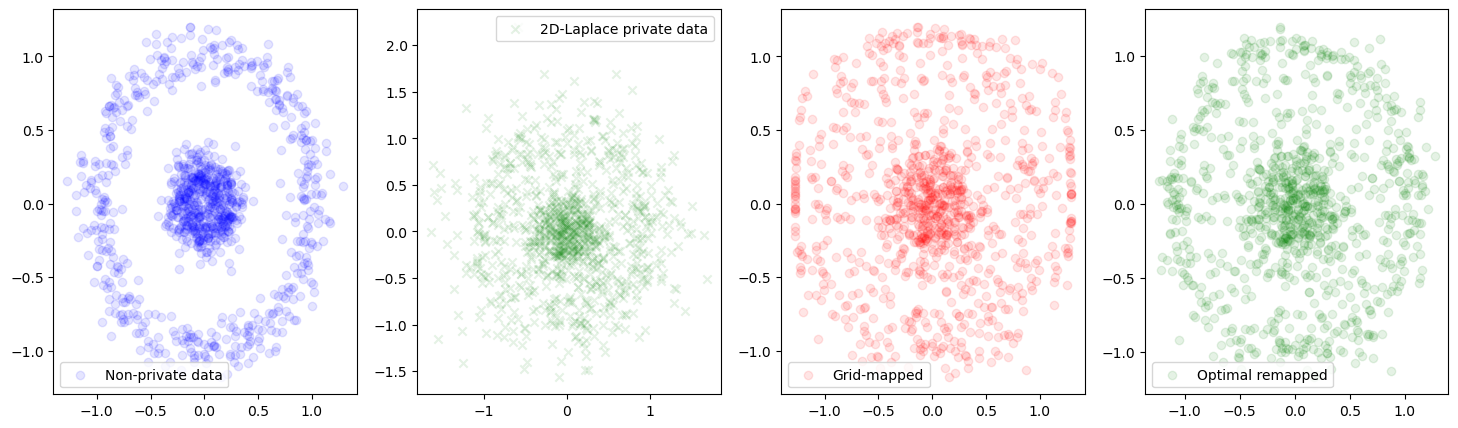

,x1,x2
0,-0.079905,0.141012
1,-0.021196,0.133811
2,0.300496,-0.310080
3,-0.884664,0.577273
4,-0.539180,0.064866
...,...,...
995,-0.000887,-0.143044
996,-0.112579,0.116499
997,-1.148861,0.001556
998,0.535685,0.414453


In [21]:
circle_mechanism = ldp_mechanism.ldp_mechanism()
circle_mechanism.randomise(circle_dataset_2d, 7, 12, plot_validation=True)

In [22]:
line_dataset = helpers.load_dataset('../data/line-dataset/line_1000.csv')
line_dataset_2d = line_dataset.iloc[:, 0:2]
line_dataset_2d.head()

,x1,x2
0,0.601034,1.535353
1,0.755945,-1.172352
2,1.354479,-0.948528
3,3.103090,0.233485
4,0.753178,0.787514


Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset  using a grid...
All data that was remapped using a grid, is optimally remapped...
Found is_remapped column, so we use that to filter
Points outside domain.... (769, 4)
Shapes (1000, 4) (1000, 3)


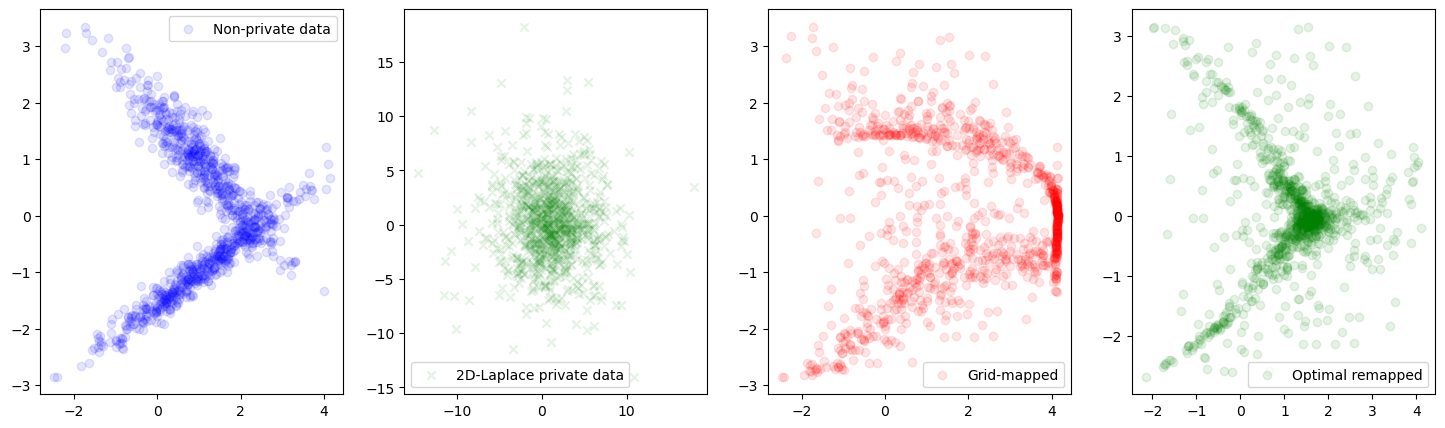

,x1,x2
0,0.757487,0.907280
1,1.277023,-0.520488
2,1.637532,-0.660417
3,3.798724,0.725810
4,1.055338,0.334398
...,...,...
995,1.647987,-0.096116
996,1.531725,-0.301346
997,2.228731,-0.010515
998,0.771327,0.489174


In [23]:
line_mechanism = ldp_mechanism.ldp_mechanism()
line_mechanism.randomise(line_dataset_2d, 0.5, 12, plot_validation=True)